# EDA — Veterinary Clinical Dataset (Kaggle)
Este notebook realiza un **análisis exploratorio de datos (EDA)** del dataset *Veteriary Clinical Dataset*.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from pathlib import Path
import sys
import importlib
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

## 1) Carga de datos

In [2]:
path = Path(r"/content/veterinary_clinical_data.csv")
df = pd.read_csv(path)

print("Shape:", df.shape)
display(df.head(10))
display(df.dtypes.to_frame("dtype"))

Shape: (10000, 10)


,AnimalName,Breed,Age,Weight_kg,MedicalHistory,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5
0,Dog,Rottweiler,6.0,32.1,Chronic illness,Anorexia,Hydrophobia,drooping ears,Diarrhea,Shyness or aggression
1,Dog,Bulldog,9.9,18.5,Vaccinated,Lethargy,Weakness,Horny growth,Fever,Coughing
2,Dog,Beagle,13.9,18.9,Parasite history,Pain,Weight loss,Weight loss,Sneezing,Drop on egg production
3,cat,Scottish Fold,5.8,6.3,Recent surgery,Vomiting,Pain,Edema in lower jaw,Pain,Weakness
4,cat,Persian,11.2,4.9,Recent surgery,Severe,Weight loss,Egg production stops,Weakness,Poor Body condition
5,Dog,Mixed Breed,4.2,13.4,Chronic illness,Weakness,Diarrhea,Weight loss,Diarrhea,Weight loss
6,Dog,Boxer,2.6,27.6,Dental issues,Indigestion,Abdminal pain,Constipation,Diarrhea,Nausea
7,Dog,Yorkshire Terrier,12.4,3.8,Previous heart condition,Weakness,Weight loss,Muscle twiching,Shivering,Vomiting
8,cat,Maine Coon,5.9,5.7,Previous kidney disease,outstretched neck,dull ness,inappetence,noisy breathing,coughing
9,Dog,Beagle,1.7,16.2,Allergies,Fever,Loss of appetite,Reduce Energy,Lameness,Swelling of joints


,dtype
AnimalName,object
Breed,object
Age,float64
Weight_kg,float64
MedicalHistory,object
Symptom_1,object
Symptom_2,object
Symptom_3,object
Symptom_4,object
Symptom_5,object


## 2) Calidad de datos y limpieza
Revisamos **valores faltantes**, **duplicados** y consistencia básica (rangos y formato de texto).

In [3]:
missing = df.isna().sum().sort_values(ascending=False)
display(missing.to_frame("missing_values"))

dup_rows = df.duplicated().sum()
print("Duplicados exactos:", dup_rows)

display(df[["Age", "Weight_kg"]].describe())

,missing_values
AnimalName,0
Breed,0
Age,0
Weight_kg,0
MedicalHistory,0
Symptom_1,0
Symptom_2,0
Symptom_3,0
Symptom_4,0
Symptom_5,0


Duplicados exactos: 20


,Age,Weight_kg
count,10000.000000,10000.000000
mean,8.428050,14.891990
std,4.639286,12.624691
min,0.500000,2.500000
25%,4.800000,5.300000
50%,8.400000,7.300000
75%,12.000000,25.500000
max,18.000000,45.000000


In [4]:
veterinary_data_df = df.copy()

In [5]:
for col in veterinary_data_df.columns:
  if veterinary_data_df[col].dtype == 'object':
    veterinary_data_df[col] = veterinary_data_df[col].astype('string')

display(veterinary_data_df.dtypes)

,0
AnimalName,string[python]
Breed,string[python]
Age,float64
Weight_kg,float64
MedicalHistory,string[python]
Symptom_1,string[python]
Symptom_2,string[python]
Symptom_3,string[python]
Symptom_4,string[python]
Symptom_5,string[python]


### Limpieza aplicada

In [6]:
df_clean = df.drop_duplicates().copy()

text_cols = df_clean.select_dtypes(include="object").columns
for c in text_cols:
    df_clean[c] = df_clean[c].astype(str).str.strip()

df_clean["Species"] = df_clean["AnimalName"].str.lower().map({"dog": "Dog", "cat": "Cat"})

removed = len(df) - len(df_clean)
print(f"Filas iniciales: {len(df)}")
print(f"Filas tras limpieza: {len(df_clean)}")
print(f"Filas eliminadas (duplicados exactos): {removed}")


missing_after = df_clean.isna().sum().sum()
print(f"Valores faltantes tras limpieza: {int(missing_after)}")
print("Imputación aplicada: NO (no hay nulos en el dataset)")

Filas iniciales: 10000
Filas tras limpieza: 9980
Filas eliminadas (duplicados exactos): 20
Valores faltantes tras limpieza: 0
Imputación aplicada: NO (no hay nulos en el dataset)


## 3) EDA obligatorio

### Edad y peso por especie
Estadísticos descriptivos (media, mediana, desviación estándar) para edad y peso en perros y gatos.

In [7]:
def descriptivos_por_especie(df_in, especie):
    sub = df_in[df_in["Species"] == especie]
    return pd.Series({
        "n": len(sub),
        "Age_mean": sub["Age"].mean(),
        "Age_median": sub["Age"].median(),
        "Age_std": sub["Age"].std(),
        "Weight_mean": sub["Weight_kg"].mean(),
        "Weight_median": sub["Weight_kg"].median(),
        "Weight_std": sub["Weight_kg"].std(),
    })

stats = pd.DataFrame({
    "Dog": descriptivos_por_especie(df_clean, "Dog"),
    "Cat": descriptivos_por_especie(df_clean, "Cat"),
}).T

display(stats)

,n,Age_mean,Age_median,Age_std,Weight_mean,Weight_median,Weight_std
Dog,5013.0,7.473988,7.5,4.082992,24.202873,25.5,11.890496
Cat,4967.0,9.410046,9.4,4.948552,5.520415,5.6,1.596712


### 1) En la distribución de edad por especie, se observa que ambas especies presentan patrones relativamente similares; sin embargo, hay diferencias importantes en la concentración de edades.

- En la especie azul (perros), la mayor frecuencia se encuentra en edades más bajas, mostrando un pico en animales jóvenes.

- En la especie naranja (gatos), la concentración aumenta en edades mayores, lo que indica que dentro del dataset hay más gatos adultos o senior en comparación con perros.

### 2) En esta gráfica se observa la diferencia clara en la distribución del peso entre perros y gatos:

- Los gatos se concentran mayormente entre 4 y 8 kg, con una distribución más estrecha.

- Los perros muestran un rango mucho más amplio, generalmente entre 10 y 40 kg, lo que refleja la mayor variabilidad entre razas y tamaños.

Estas visualizaciones ayudan a identificar patrones de variación entre especies y aportan contexto para análisis posteriores como correlaciones o diagnósticos asociados.

/tmp/ipython-input-4000284269.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Especie")


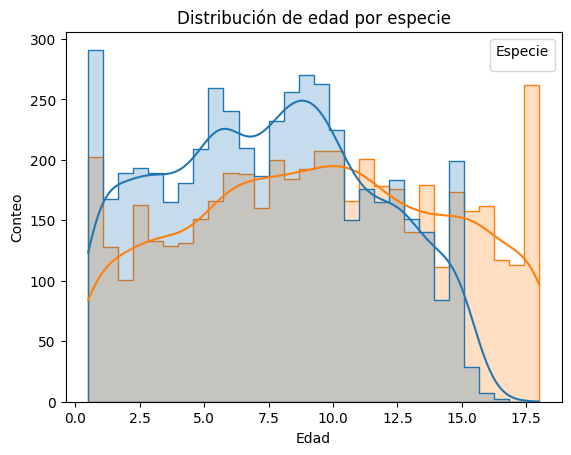

/tmp/ipython-input-4000284269.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Especie")


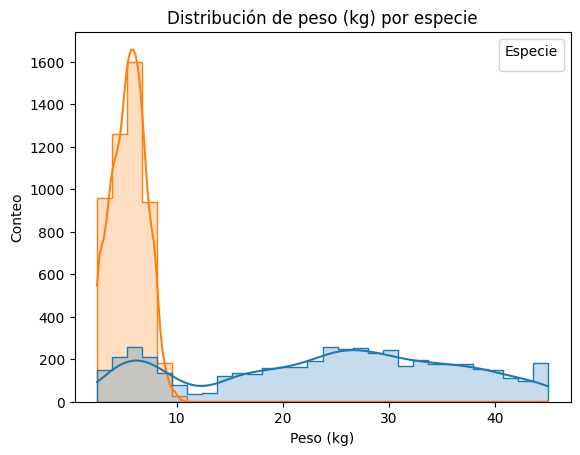

In [8]:
# Distribución de edad por especie
plt.figure()
sns.histplot(data=df_clean, x="Age", hue="Species", kde=True, bins=30, element="step")
plt.title("Distribución de edad por especie")
plt.xlabel("Edad")
plt.ylabel("Conteo")
plt.legend(title="Especie")
plt.show()

# Distribución de peso por especie
plt.figure()
sns.histplot(data=df_clean, x="Weight_kg", hue="Species", kde=True, bins=30, element="step")
plt.title("Distribución de peso (kg) por especie")
plt.xlabel("Peso (kg)")
plt.ylabel("Conteo")
plt.legend(title="Especie")
plt.show()

### Distribución de especies
Conteo por especie (barra y pastel).

,count
Species,
Dog,5013
Cat,4967


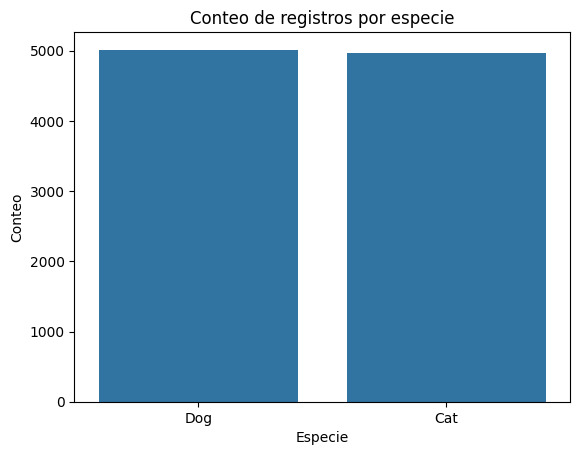

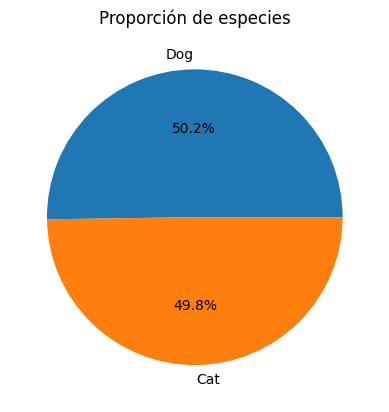

In [9]:
species_counts = df_clean["Species"].value_counts()
display(species_counts.to_frame("count"))

plt.figure()
sns.barplot(x=species_counts.index, y=species_counts.values)
plt.title("Conteo de registros por especie")
plt.xlabel("Especie")
plt.ylabel("Conteo")
plt.show()

plt.figure()
plt.pie(species_counts.values, labels=species_counts.index, autopct="%1.1f%%")
plt.title("Proporción de especies")
plt.show()

### Síntomas/diagnósticos más frecuentes
El dataset **no tiene columna de diagnóstico**. Analizamos los síntomas combinando `Symptom_1..Symptom_5`.
Mostramos el top 10 y una visualización.

,count
Fever,3519
Weight loss,3061
Diarrhea,2978
Pain,2683
Coughing,2665
Lethargy,2601
Vomiting,2598
Weakness,2539
Sneezing,2431
Anorexia,2401


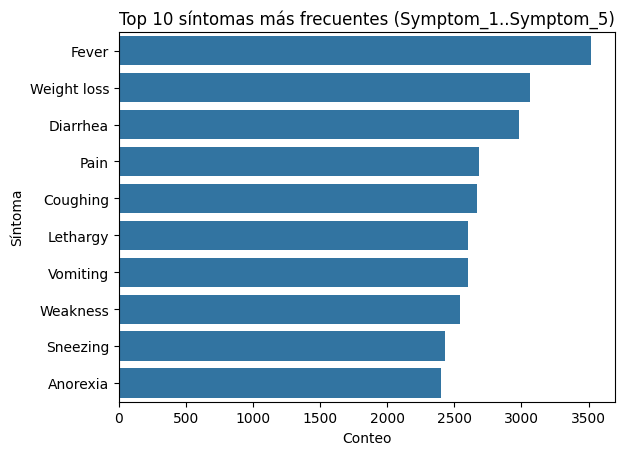

In [10]:
sym_cols = [c for c in df_clean.columns if c.lower().startswith("symptom")]
sym_long = pd.concat([df_clean[c].astype(str).str.strip() for c in sym_cols], ignore_index=True)

top_symptoms = sym_long.value_counts().head(10)
display(top_symptoms.to_frame("count"))

plt.figure()
sns.barplot(y=top_symptoms.index, x=top_symptoms.values)
plt.title("Top 10 síntomas más frecuentes (Symptom_1..Symptom_5)")
plt.xlabel("Conteo")
plt.ylabel("Síntoma")
plt.show()

### Patrones entre edad, peso y categoría clínica
Como alternativa al diagnóstico, usamos:
- `MedicalHistory` (historial médico)
- `Symptom_1` (síntoma principal)

Analizamos promedios y boxplots por especie.

###Decidimos utilizar boxplots porque este tipo de gráfica permite comparar la distribución de edad y peso entre diferentes categorías del MedicalHistory de una forma muy visual y directa. En particular, los boxplots ayudan a:

- Identificar la variación dentro de cada historial médico
Podemos ver si ciertos antecedentes (como alergias, cirugías recientes o enfermedades crónicas) se asocian con animales más jóvenes, mayores, más pesados o más ligeros.

- Comparar rápidamente perros vs. gatos
Como aparecen ambos en la misma gráfica, es fácil detectar diferencias entre especies para cada condición médica.

- Detectar valores atípicos (outliers)
Esto es útil para saber si algún historial médico está relacionado con casos extremos, como animales demasiado jóvenes, muy viejos o con pesos poco usuales.

- Observar tendencias generales
Por ejemplo, si ciertos diagnósticos son más comunes en animales mayores o en perros de mayor peso.

,n,Age_mean,Age_median,Weight_mean,Weight_median
MedicalHistory,,,,,
Skin conditions history,1016,8.087402,7.75,15.164764,7.8
No previous conditions,991,8.657619,8.70,14.952573,7.2
Recent surgery,953,8.239664,8.00,15.830640,7.8
Chronic illness,938,8.239126,7.80,15.471109,7.6
Not vaccinated,920,8.248370,8.10,15.358261,7.5
Allergies,896,8.404799,8.30,15.243304,7.6
Parasite history,886,8.380700,8.40,15.120542,7.4
Dental issues,885,8.703842,8.70,13.637514,6.8
Previous kidney disease,869,8.445339,8.70,14.619793,7.4


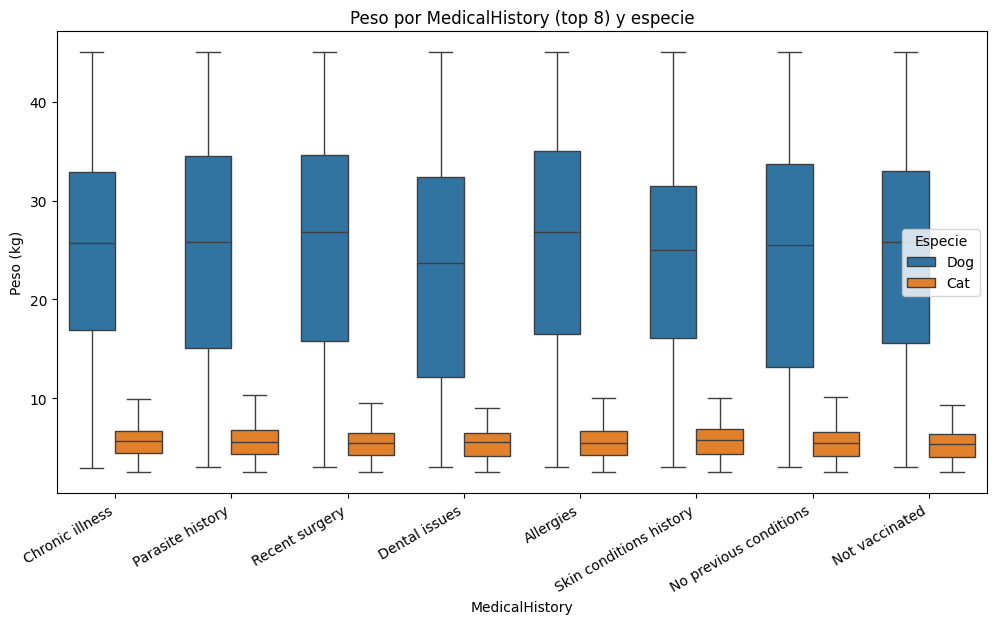

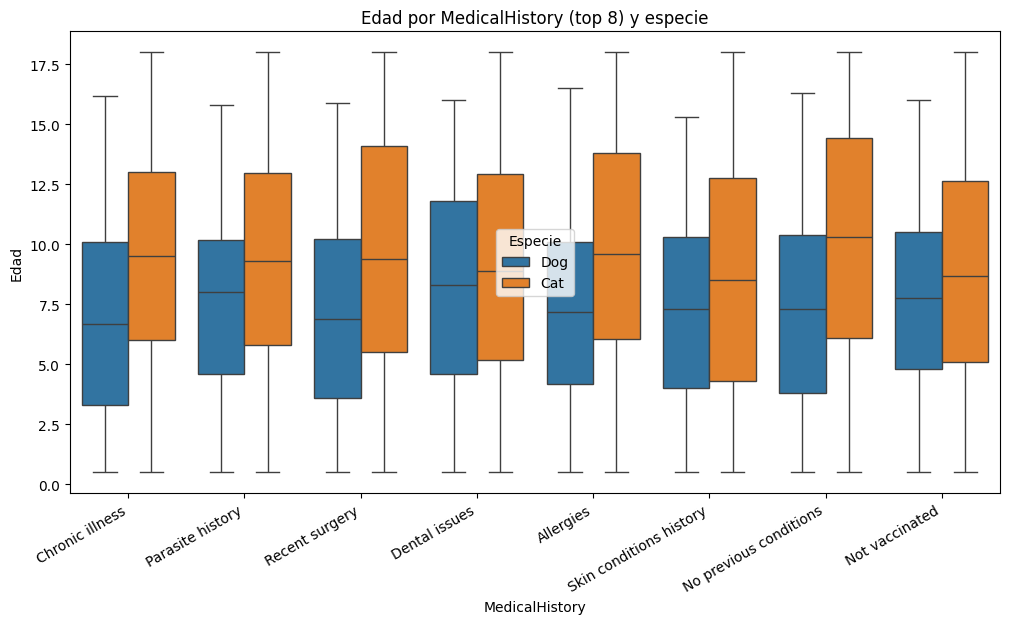

In [11]:
mh_summary = df_clean.groupby("MedicalHistory").agg(
    n=("MedicalHistory", "size"),
    Age_mean=("Age", "mean"),
    Age_median=("Age", "median"),
    Weight_mean=("Weight_kg", "mean"),
    Weight_median=("Weight_kg", "median"),
).sort_values("n", ascending=False)

display(mh_summary)

top_mh = mh_summary.head(8).index.tolist()
sub_mh = df_clean[df_clean["MedicalHistory"].isin(top_mh)].copy()

plt.figure(figsize=(12, 6))
sns.boxplot(data=sub_mh, x="MedicalHistory", y="Weight_kg", hue="Species")
plt.title("Peso por MedicalHistory (top 8) y especie")
plt.xlabel("MedicalHistory")
plt.ylabel("Peso (kg)")
plt.xticks(rotation=30, ha="right")
plt.legend(title="Especie")
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=sub_mh, x="MedicalHistory", y="Age", hue="Species")
plt.title("Edad por MedicalHistory (top 8) y especie")
plt.xlabel("MedicalHistory")
plt.ylabel("Edad")
plt.xticks(rotation=30, ha="right")
plt.legend(title="Especie")
plt.show()

###Usamos boxplots porque permiten comparar rápidamente cómo varían la edad y el peso entre distintos síntomas. Con ellos podemos ver:

- La distribución completa (mediana, rango, variación).

- Diferencias entre perros y gatos dentro de cada síntoma.

- Patrones clínicos, como síntomas más comunes en animales más jóvenes o más pesados.

- Valores atípicos, que ayudan a identificar casos inusuales.

,n,Age_mean,Weight_mean
Symptom_1,,,
Fever,1385,8.320722,15.002671
Weight loss,539,8.383117,14.708163
Weakness,500,8.500200,14.250800
Diarrhea,491,8.651731,15.399593
Vomiting,491,8.369450,15.581466
Sneezing,489,8.455828,13.677505
Pain,477,8.081551,15.559748
Lethargy,475,8.421474,14.938526
Coughing,470,8.344255,15.055106


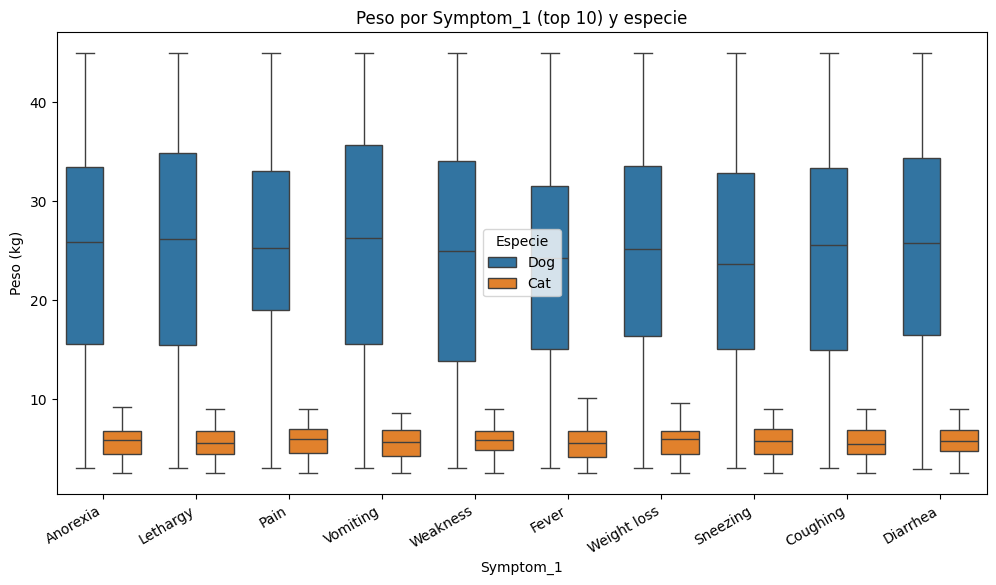

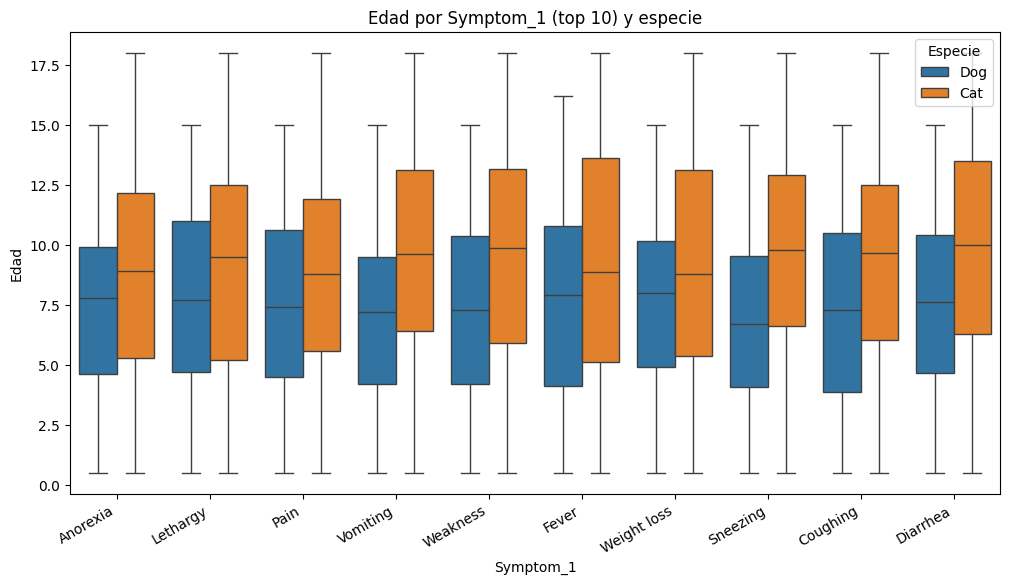

In [12]:
sym1_summary = df_clean.groupby("Symptom_1").agg(
    n=("Symptom_1", "size"),
    Age_mean=("Age", "mean"),
    Weight_mean=("Weight_kg", "mean"),
).sort_values("n", ascending=False)

display(sym1_summary.head(15))

top_sym1 = sym1_summary.head(10).index.tolist()
sub_s1 = df_clean[df_clean["Symptom_1"].isin(top_sym1)].copy()

plt.figure(figsize=(12, 6))
sns.boxplot(data=sub_s1, x="Symptom_1", y="Weight_kg", hue="Species")
plt.title("Peso por Symptom_1 (top 10) y especie")
plt.xlabel("Symptom_1")
plt.ylabel("Peso (kg)")
plt.xticks(rotation=30, ha="right")
plt.legend(title="Especie")
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=sub_s1, x="Symptom_1", y="Age", hue="Species")
plt.title("Edad por Symptom_1 (top 10) y especie")
plt.xlabel("Symptom_1")
plt.ylabel("Edad")
plt.xticks(rotation=30, ha="right")
plt.legend(title="Especie")
plt.show()

# Se dividen en grupos:
**Graves:** son síntomas ante los que hay que buscar ayuda inmediata para que el animal no muera.

**Medios:** son síntomas que hay que tener en cuenta y llevar al veterinario en cuanto se pueda. No hay peligro de muerte.

**Leves:** son síntomas que no implican un riesgo de muerte ni gran preocupación. Solo observar su duración y si hay otros síntomas.

In [13]:
#Se filtrarán por síntomas graves, medios y leves:
sintomas_cols = ['Symptom_1','Symptom_2','Symptom_3','Symptom_4','Symptom_5']
graves = ['fever', 'diarrhea', 'ulcerated ear', 'dyspnea', 'dehydration', 'cough']
medios = ['vomiting', 'yellow eyes']
leves = ['lethargia', 'loss of appetite']
filtro_graves = df[sintomas_cols].apply(lambda fila: any(s in fila.values for s in graves), axis=1)
df_filtrado_graves = df.loc[filtro_graves, sintomas_cols]


filtro_medios = df[sintomas_cols].apply(lambda fila: any(s in fila.values for s in medios), axis=1)
df_filtrado_medios = df.loc[filtro_medios, sintomas_cols]


filtro_leves = df[sintomas_cols].apply(lambda fila: any(s in fila.values for s in leves), axis=1)
df_filtrado_leves = df.loc[filtro_leves, sintomas_cols]


display(df_filtrado_graves)
display(df_filtrado_medios)
display(df_filtrado_leves)

,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5
120,Edema,diarrhea,Nasal Discharge,Decresed egg production,Sneezing
206,fever,loss of appetite,rapid pulse and heart rates,lameness in affected leg,depression
213,nasal discharge,depression,muscular stiffness,fever,swollen lymph nodes
231,fever,loss of appetite,rapid pulse and heart rates,lameness in affected leg,depression
311,lack of appetite,high body temperaure,diarrhea,sudden death,loss of appetite
...,...,...,...,...,...
9835,change their normal behaviour,stop drinking,Pains,diarrhea,stop eating
9874,cough,sneeze,droopy wings,twisted neck,droopy wings
9904,loss of appetite,high body temperaure,lack of appetite,diarrhea,sudden death
9979,fever,loss of appetite,rapid pulse and heart rates,lameness in affected leg,depression


,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5
180,burning ache or pain,vomiting,loss of appetite,experiencing changes in weight,pain and bloating
1193,burning ache or pain,vomiting,loss of appetite,experiencing changes in weight,pain and bloating
1381,loss of appetite,vomiting,pain and bloating,experiencing changes in weight,burning ache or pain
2152,Pain,Weakness,Coughing,vomiting,Pustulses
2723,nausea,vomiting,loss of appetite,experiencing changes in weight,pain and bloating
3290,nausea,vomiting,loss of appetite,experiencing changes in weight,pain and bloating
4243,burning ache or pain,vomiting,loss of appetite,experiencing changes in weight,pain and bloating
4589,vomiting,Lethargy,Lethargy,Weakness,Fast breathing
4648,nausea,vomiting,loss of appetite,experiencing changes in weight,pain and bloating
4870,experiencing changes in weight,pain and bloating,burning ache or pain,vomiting,loss of appetite


,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5
23,Smell,Diarrhea,loss of appetite,Excess sleeping,Folded Ears
29,Fever,loss of appetite,Depression,Loss of appetite,Pains
97,emaciation,loss in weight,loss of appetite,Weakness,diarrhoea
101,loss of appetite,Diarrhea,Lession on cat skin,Coughing,Vomiting
140,Changes in outer layer skin,Swelling of eye,loss of appetite,Lethargy,Respiratory infection
...,...,...,...,...,...
9886,Egg production stops,loss of appetite,Weight loss,Constipation,Broody behavior
9904,loss of appetite,high body temperaure,lack of appetite,diarrhea,sudden death
9939,burning ache or pain,vomiting,loss of appetite,experiencing changes in weight,pain and bloating
9979,fever,loss of appetite,rapid pulse and heart rates,lameness in affected leg,depression


### Usamos gráficos de barras porque son la mejor forma de comparar el peso promedio entre distintas razas dentro de cada especie. Estos gráficos permiten:

- Ver rápidamente qué razas pesan más o menos dentro de gatos y perros.

- Comparar diferencias claras entre razas sin complicar la visualización.

- Facilitar la interpretación clínica, ya que ciertas razas tienden a ser naturalmente más grandes o pequeñas.

/tmp/ipython-input-3977021406.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=peso_gatos, x='Breed', y='Weight_kg', palette='pastel', ax=axes[0])
/tmp/ipython-input-3977021406.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=peso_perros, x='Breed', y='Weight_kg', palette='pastel', ax=axes[1])


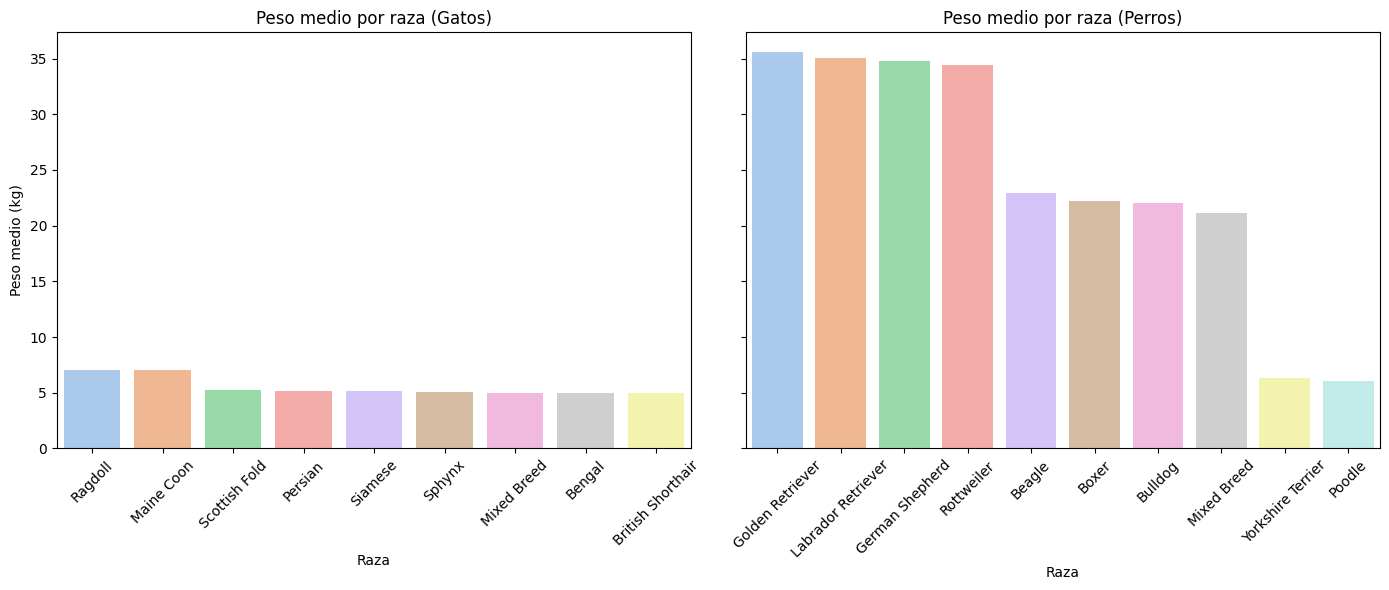

In [14]:
# Agrupar por raza y calcular el peso medio
peso_por_raza = veterinary_data_df.groupby(['AnimalName','Breed'])['Weight_kg'].mean().reset_index()

#Separar gatos y perros por peso
peso_gatos = peso_por_raza[peso_por_raza['AnimalName'] == 'cat'].sort_values(by='Weight_kg', ascending=False)
peso_perros = peso_por_raza[peso_por_raza['AnimalName'] == 'Dog'].sort_values(by='Weight_kg', ascending=False)

# Crear figura con 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

# Gráfico de gatos
sns.barplot(data=peso_gatos, x='Breed', y='Weight_kg', palette='pastel', ax=axes[0])
axes[0].set_title("Peso medio por raza (Gatos)")
axes[0].set_xlabel("Raza")
axes[0].set_ylabel("Peso medio (kg)")
axes[0].tick_params(axis='x', rotation=45)

# Gráfico de perros
sns.barplot(data=peso_perros, x='Breed', y='Weight_kg', palette='pastel', ax=axes[1])
axes[1].set_title("Peso medio por raza (Perros)")
axes[1].set_xlabel("Raza")
axes[1].set_ylabel("Peso medio (kg)")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Se harán mapas de calor para ver cómo se correlacionan las distintas variables numéricas.

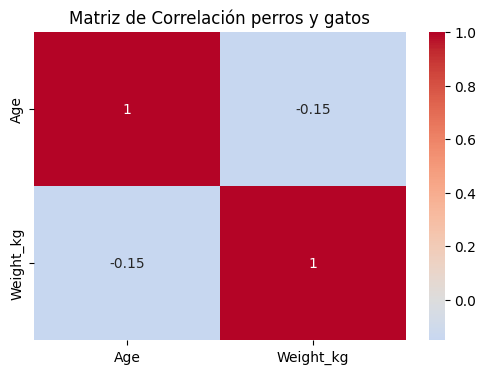

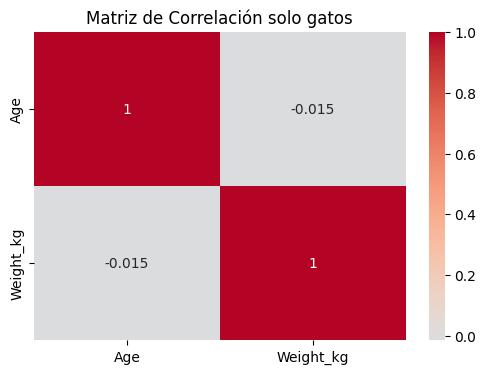

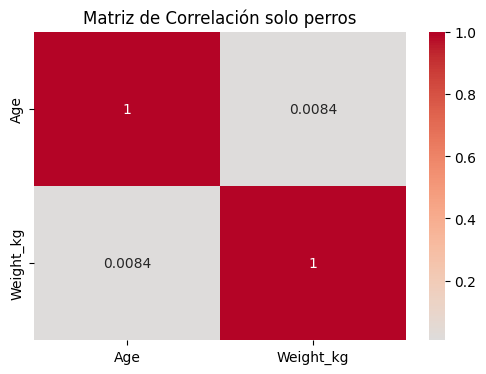

In [15]:
# Matriz de correlación de gatos y perros juntos.
plt.figure(figsize=(6, 4))
correlation_matrix = df[['Age', 'Weight_kg']].corr()
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            center=0)
plt.title("Matriz de Correlación perros y gatos")
plt.show()

#Separamos gatos (.lower() por si hay Cat) por edad y peso.
df_gatos = df[df['AnimalName'].str.lower() == 'cat']
df_gatos_edad_peso = df_gatos[['Age', 'Weight_kg']]

# Matriz de correlación de gatos solamente.
plt.figure(figsize=(6, 4))
correlation_matrix = df_gatos_edad_peso.corr()
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            center=0)
plt.title("Matriz de Correlación solo gatos")
plt.show()

#Separamos perros (.lower() por si hay Cat) por edad y peso.
df_perros = df[df['AnimalName'].str.lower() == 'dog']
df_perros_edad_peso = df_perros[['Age', 'Weight_kg']]

# Matriz de correlación de gatos solamente.
plt.figure(figsize=(6, 4))
correlation_matrix = df_perros_edad_peso.corr()
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            center=0)
plt.title("Matriz de Correlación solo perros")
plt.show()

Con estas gráficas podemos ver que no tiene relación la edad y el peso de los perros en general. Esto tiene sentido porque mezclamos animales de razas y distintos tamaños.

Por eso, decidimos hacer un mapa de calor separando perros y gatos.

La de gatos podemos ver que hay menos relación todavía, eso también tiene sentido porque como se puede observar en la gráfica de barras que mide el promedio del peso de gatos por raza es prácticamente igual. Es decir, que los gatos en general tienen el mismo peso de forma promedia.

En la de los perros hay un poco más de correlación positiva comparándola con la de los gatos, pero tampoco hay una relación lineal. Esto también tiene sentido porque, por ejemplo, un perro de raza grande de 1 año podría pesar igual o más que un perro adulto de raza pequeña.

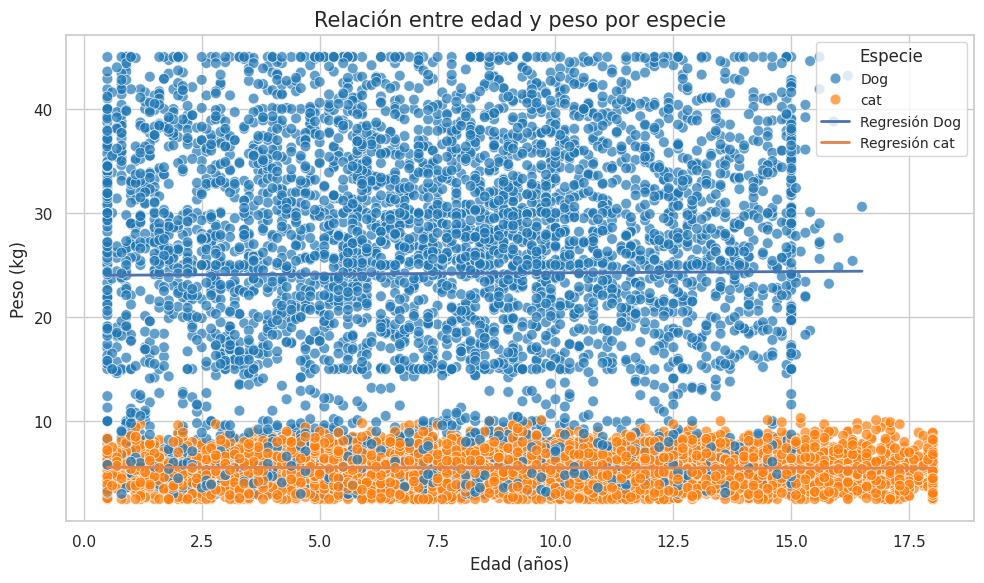

In [16]:
# --- Configuración de estilo ---
sns.set(style="whitegrid", context="notebook")

# --- Crear scatter plot diferenciado por especie ---
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=df,
    x="Age",
    y="Weight_kg",
    hue="AnimalName",
    palette={"Dog": "#1f77b4", "cat": "#ff7f0e"},
    alpha=0.7,
    s=60
)

# --- Ajustar regresión lineal para cada especie por separado ---
species_unique = df['AnimalName'].unique()

for sp in species_unique:
    subset = df[df['AnimalName'] == sp]

    # Reshape para scikit-learn
    X = subset['Age'].values.reshape(-1, 1)
    y = subset['Weight_kg'].values

    model = LinearRegression()
    model.fit(X, y)

    # Predicciones para dibujar la línea
    age_range = np.linspace(subset['Age'].min(), subset['Age'].max(), 100).reshape(-1, 1)
    weight_pred = model.predict(age_range)

    plt.plot(
        age_range,
        weight_pred,
        label=f"Regresión {sp}",
        linewidth=2
    )

# --- Títulos y etiquetas ---
plt.title("Relación entre edad y peso por especie", fontsize=15)
plt.xlabel("Edad (años)", fontsize=12)
plt.ylabel("Peso (kg)", fontsize=12)
plt.legend(title="Especie", fontsize=10)
plt.tight_layout()
plt.show()

In [17]:
# ====================
# REGRESIÓN LINEAL - Versión Mínima
# ====================
print("\n📈 REGRESIÓN LINEAL SIMPLE")

# Modelo
modelo = smf.ols('Weight_kg ~ Age', data=df).fit()

# Resultados esenciales
params = modelo.params
conf_int = modelo.conf_int()

print(f"\n📊 ECUACIÓN:")
print(f"Weight_kg = {params['Intercept']:.3f} + {params['Age']:.3f} * Age")

print(f"\n📈 MÉTRICAS:")
print(f"• R² = {modelo.rsquared:.3f} ({modelo.rsquared*100:.1f}%)")
print(f"• p-valor pendiente = {modelo.pvalues['Age']:.5f}")
print(f"• IC95% pendiente = [{conf_int.loc['Age', 0]:.3f}, {conf_int.loc['Age', 1]:.3f}]")

print(f"\n💡 INTERPRETACIÓN:")
print(f"Por cada 1 año adicional de vida del animal, su peso aumenta {params['Age']:.3f}")
print(f"Significativo: {'SÍ' if modelo.pvalues['Age'] < 0.05 else 'NO'}")


📈 REGRESIÓN LINEAL SIMPLE

📊 ECUACIÓN:
Weight_kg = 18.356 + -0.411 * Age

📈 MÉTRICAS:
• R² = 0.023 (2.3%)
• p-valor pendiente = 0.00000
• IC95% pendiente = [-0.464, -0.358]

💡 INTERPRETACIÓN:
Por cada 1 año adicional de vida del animal, su peso aumenta -0.411
Significativo: SÍ


In [18]:
# ====================
# INTERPRETACIÓN PASO A PASO
# ====================
print("\n🎯 INTERPRETACIÓN PARA NO ESTADÍSTICOS:")
print("-"*40)

# Extraer los coeficientes
intercepto = modelo.params['Intercept']
pendiente = modelo.params['Age']

print(f"1. ECUACIÓN DEL MODELO:")
print(f"   Peso (kg) = {intercepto:.3f} + {pendiente:.3f} * Edad")
print()

print(f"2. INTERPRETACIÓN DE COEFICIENTES:")
print(f"   • Intercepto (β₀): {intercepto:.3f}")
print(f"     'Cuando la edad es 0 años, el peso esperado es {intercepto:.3f} kg.'")
print(f"     (Interpretación práctica limitada, ya que un peso de {intercepto:.3f} kg para un recién nacido es alto)")
print()
print(f"   • Pendiente (β₁): {pendiente:.3f}")
print(f"     'Por cada año adicional de vida del animal,\n     el peso cambia en {pendiente:.3f} kg en promedio.'")
print(f"     'Por cada 10 años adicionales, el peso cambia en {pendiente*10:.3f} kg.'")
print()

# Ejemplo concreto
edad_ejemplo = 5 # Definir una edad de ejemplo
peso_predicho = intercepto + pendiente * edad_ejemplo
print(f"3. EJEMPLO CONCRETO:")
print(f"   Para una edad de {edad_ejemplo} años:")
print(f"   Peso esperado = {intercepto:.3f} + {pendiente:.3f}*{edad_ejemplo}")
print(f"                    = {peso_predicho:.2f} kg")
print()

# R-cuadrado
r_cuadrado = modelo.rsquared
print(f"4. BONDAD DEL AJUSTE (R²): {r_cuadrado:.3f} o {r_cuadrado*100:.1f}%")
print(f"   'La edad explica el {r_cuadrado*100:.1f}% de la variación")
print(f"    en el peso.'")
print(f"   'No es un ajuste razonable para estos datos, ya que solo explica el {r_cuadrado*100:.1f}% de la variabilidad del peso.'")
print()

# Significancia estadística
p_valor = modelo.pvalues['Age']
print(f"5. SIGNIFICANCIA ESTADÍSTICA:")
print(f"   p-valor para la pendiente: {p_valor:.4f}")
if p_valor < 0.05:
    print(f"   ✓ p < 0.05 → Rechazamos H₀: 'La pendiente es prácticamente cero'")
    print(f"   ✓ No hay evidencia de que existe una relación lineal significativa")
else:
    print(f"   ✗ p ≥ 0.05 → No rechazamos H₀")
    print(f"   ✗ Hay evidencia suficiente de una relación lineal significativa")


🎯 INTERPRETACIÓN PARA NO ESTADÍSTICOS:
----------------------------------------
1. ECUACIÓN DEL MODELO:
   Peso (kg) = 18.356 + -0.411 * Edad

2. INTERPRETACIÓN DE COEFICIENTES:
   • Intercepto (β₀): 18.356
     'Cuando la edad es 0 años, el peso esperado es 18.356 kg.'
     (Interpretación práctica limitada, ya que un peso de 18.356 kg para un recién nacido es alto)

   • Pendiente (β₁): -0.411
     'Por cada año adicional de vida del animal,
     el peso cambia en -0.411 kg en promedio.'
     'Por cada 10 años adicionales, el peso cambia en -4.110 kg.'

3. EJEMPLO CONCRETO:
   Para una edad de 5 años:
   Peso esperado = 18.356 + -0.411*5
                    = 16.30 kg

4. BONDAD DEL AJUSTE (R²): 0.023 o 2.3%
   'La edad explica el 2.3% de la variación
    en el peso.'
   'No es un ajuste razonable para estos datos, ya que solo explica el 2.3% de la variabilidad del peso.'

5. SIGNIFICANCIA ESTADÍSTICA:
   p-valor para la pendiente: 0.0000
   ✓ p < 0.05 → Rechazamos H₀: 'La pendiente

Con este contraste de hipótesis nula comprobamos que no hay relación lineal significativa entre la edad y el peso de los perros y gatos.

Por eso, nuestro siguiente paso será dividir las razas de los perros en 3 grupos parecidos, tal y como se observa en la gráfica de barras que mide el promedio del peso de los perros por raza.

Con esos filtros haremos las gráficas de dispersión para comprobar si hay correlación en esos grupos entre edad y peso.

In [19]:
#Se filtrarán por razas de perros:
raza_cols = ['Breed']

grandes = ['German Shepperd','Rottweiler', 'Golden Retriever', 'Labrador Retriever']
filtro_grandes = df['Breed'].str.lower().isin([b.lower() for b in grandes])
df_filtrado_grandes = df.loc[filtro_grandes, raza_cols]
display(df_filtrado_grandes.head())


medianas = ['Beagle', 'Boxer', 'Bulldog', 'Mixed Breed']
filtro_medianas = df['Breed'].str.lower().isin([b.lower() for b in medianas])
df_filtrado_medianas = df.loc[filtro_medianas, raza_cols]
display(df_filtrado_medianas.head())


pequenas = ['Yorkshire Terrier', 'Poodle']
filtro_pequenas = df['Breed'].str.lower().isin([b.lower() for b in pequenas])
df_filtrado_pequenas = df.loc[filtro_pequenas, raza_cols]
display(df_filtrado_pequenas.head())



,Breed
0,Rottweiler
12,Golden Retriever
19,Golden Retriever
24,Rottweiler
50,Rottweiler


,Breed
1,Bulldog
2,Beagle
5,Mixed Breed
6,Boxer
9,Beagle


,Breed
7,Yorkshire Terrier
13,Yorkshire Terrier
20,Poodle
29,Yorkshire Terrier
42,Yorkshire Terrier


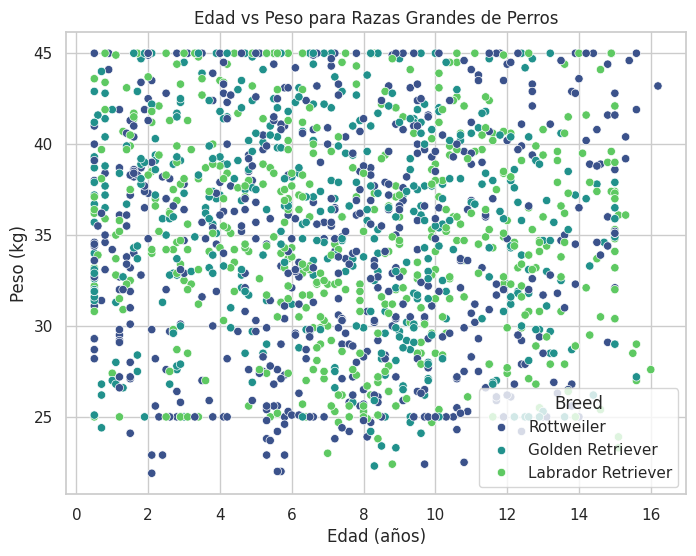

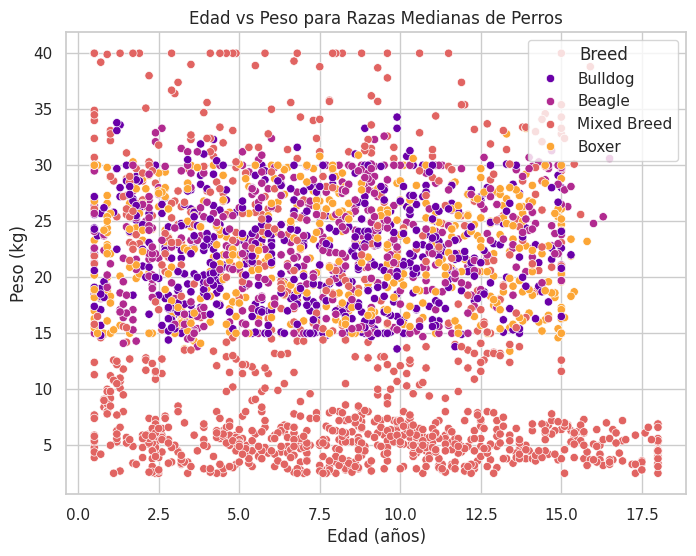

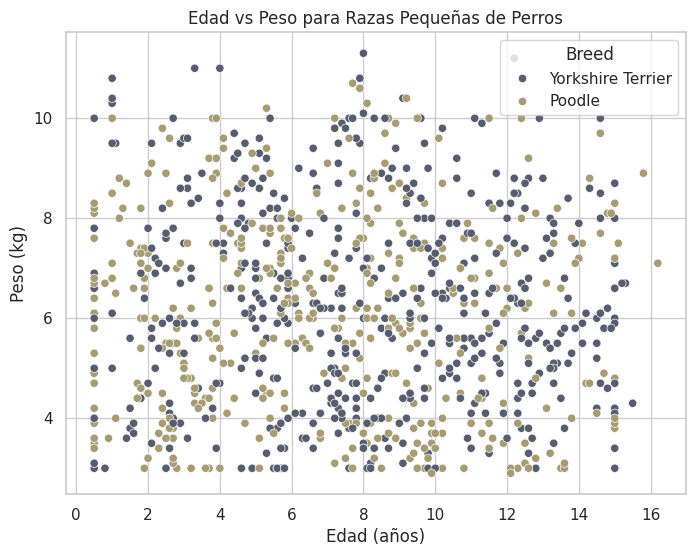

In [20]:
# Se crean gráficos de dispersión para los grupos hechos.

# Grandes
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df[filtro_grandes], x='Age', y='Weight_kg', hue='Breed', palette='viridis')
plt.title('Edad vs Peso para Razas Grandes de Perros')
plt.xlabel('Edad (años)')
plt.ylabel('Peso (kg)')
plt.show()

# Medianos
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df[filtro_medianas], x='Age', y='Weight_kg', hue='Breed', palette='plasma')
plt.title('Edad vs Peso para Razas Medianas de Perros')
plt.xlabel('Edad (años)')
plt.ylabel('Peso (kg)')
plt.show()

# Pequeños
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df[filtro_pequenas], x='Age', y='Weight_kg', hue='Breed', palette='cividis')
plt.title('Edad vs Peso para Razas Pequeñas de Perros')
plt.xlabel('Edad (años)')
plt.ylabel('Peso (kg)')
plt.show()

En estas gráficas seguimos viendo que aunque separemos por perros y agrupemos en razas similares no hay relación lineal. Así que, haremos las gráficas comparando edad y peso dentro de la misma raza.

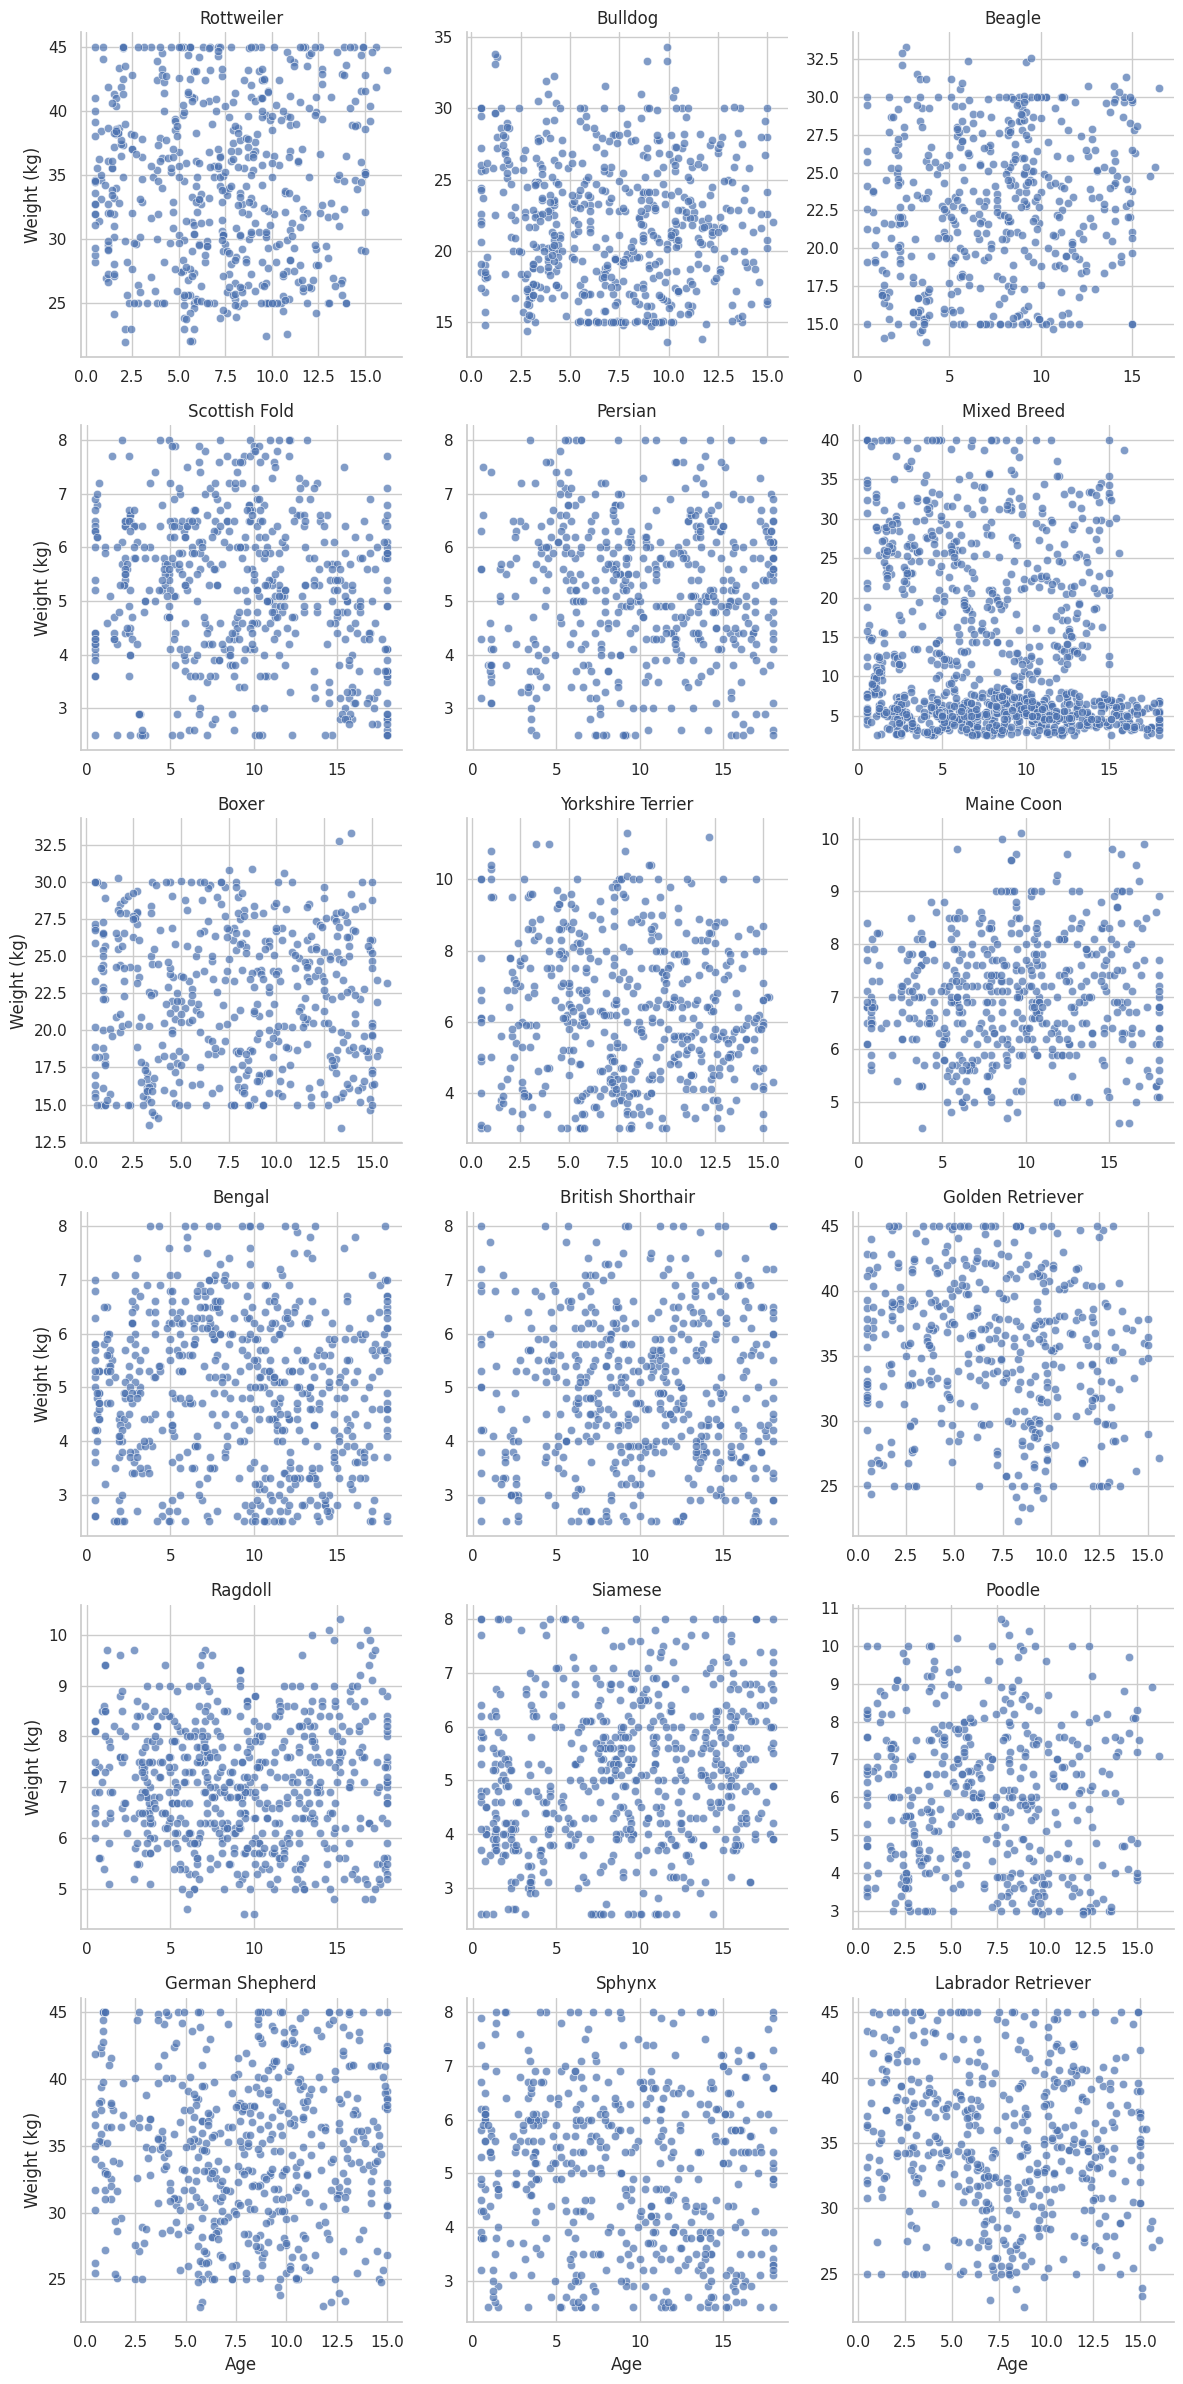

In [21]:
# FacetGrid crea un subplot por cada valor único de 'Breed'
g = sns.FacetGrid(df, col="Breed", col_wrap=3, height=4, sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x="Age", y="Weight_kg", alpha=0.7)

g.set_axis_labels("Age", "Weight (kg)")
g.set_titles(col_template="{col_name}")  #título con el nombre de la raza
plt.show()

Si hacemos las gráficas de dispersión por raza tampoco hay relación lineal (ni polinómica). Así que podemos concluir que en los perros y gatos de estas razas no hay relación lineal entre su peso y edad. Esto tiene sentido porque por ejemplo, un perro que sea pastor alemán con poco más de medio año puede tener aproximadamente el mismo peso que otro pastor alemán de 8 años.